In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

In [2]:
# loading the data
df = pd.read_csv("irises.csv", sep="|")

In [4]:
df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [5]:
# cleaning time!
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
Sepal.Length    150 non-null float64
Sepal.Width     149 non-null float64
Petal.Length    150 non-null float64
Petal.Width     150 non-null object
Species         150 non-null object
dtypes: float64(3), object(2)
memory usage: 7.0+ KB


In [6]:
# let's investigate why Petal.Width isn't numeric and adjust its data type
df["Petal.Width"].unique()

array(['0.2', '0.4', '0.3', '0.1', '0.5', '0.6', '1.4', '1.5', '1.3',
       '1.6', '1', '1.1', '1.8', '1.2', '1.7', '2.5', '1.9', '2.1', '2.2',
       '2', '2.4', '2.3', '2,2'], dtype=object)

In [7]:
df["Petal.Width"] = pd.to_numeric(df["Petal.Width"].str.replace(",", "."))

In [8]:
# now everything's fine
df.dtypes

Sepal.Length    float64
Sepal.Width     float64
Petal.Length    float64
Petal.Width     float64
Species          object
dtype: object

In [9]:
# one missing value for Sepal.Width and negative value for Sepal.Length which doesn't make any sense
df.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,149.000000,150.000000,150.000000
mean,5.779333,3.061745,3.758000,1.199333
std,1.197721,0.433963,1.765298,0.762238
min,-4.800000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [10]:
# let's check which of the species is the missing value and replace it with the mean of its class
df[df["Sepal.Width"].isnull()]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
82,5.5,NaN,3.7,1.0,versicolor


In [11]:
df['Sepal.Width'].fillna(df["Sepal.Width"][df["Species"] == "versicolor"].mean(), inplace=True)

In [12]:
# let's check which of the species has negative Sepal.Length and replace it with the mean of its class
df[df["Sepal.Length"] < 0]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
25,-4.8,3.4,1.9,0.2,setosa


In [ ]:
non_negative_setosa = df["Sepal.Length"][df["Sepal.Length"] > 0][df["Species"] == "setosa"]
df["Sepal.Length"][df["Sepal.Length"] < 0] = non_negative_setosa.mean()

In [14]:
# now everything seems fine
df.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.844735,3.059850,3.758000,1.199333
std,0.826465,0.433126,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


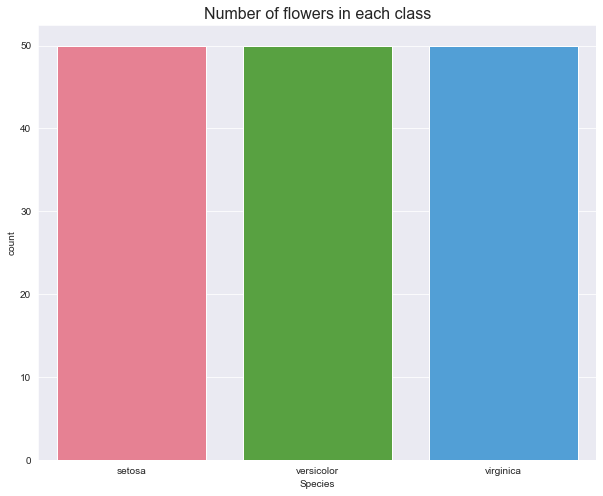

In [15]:
# some basic exploration - our dataset is balanced
sns.set_style("darkgrid")
plt.figure(figsize=(10, 8))
sns.countplot(x="Species", data=df, palette="husl").set_title(
    "Number of flowers in each class", 
    fontsize=16)
plt.savefig("plot1.png")

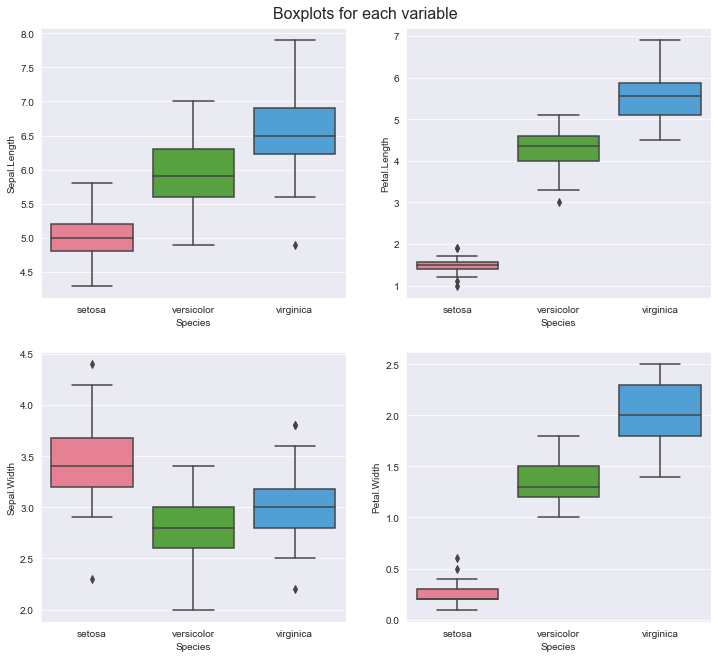

In [16]:
plt.figure(figsize=(12,10)).suptitle("Boxplots for each variable", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.subplot(2,2,1)
sns.boxplot(x="Species",y="Sepal.Length",data=df, palette="husl")
plt.subplot(2,2,2)
sns.boxplot(x="Species",y="Petal.Length",data=df, palette="husl")
plt.subplot(2,2,3)
sns.boxplot(x="Species",y="Sepal.Width",data=df, palette="husl")
plt.subplot(2,2,4)
sns.boxplot(x="Species",y="Petal.Width",data=df, palette="husl")
plt.savefig("plot2.png")

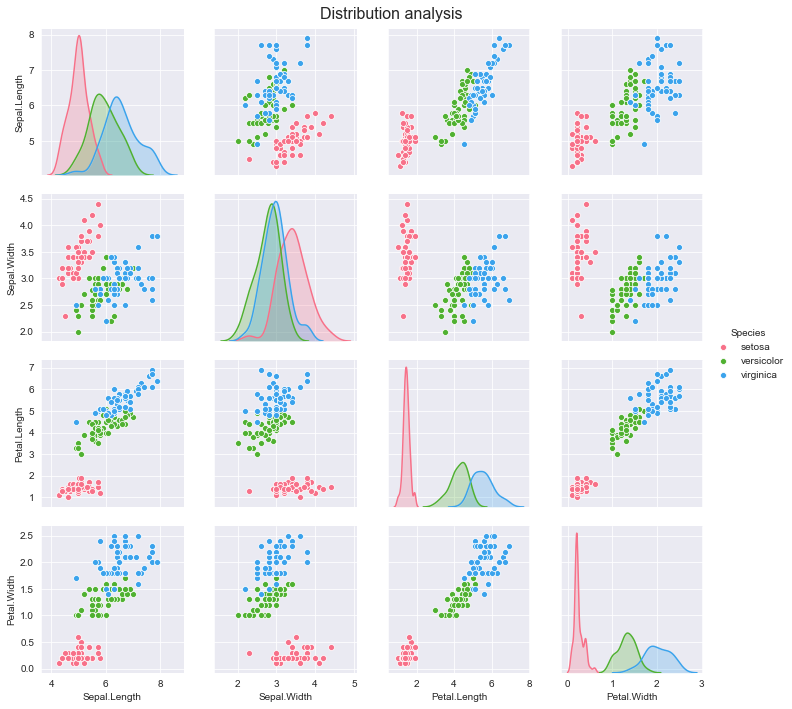

In [17]:
# more of distributions analysis - warnings can be ignored for now
sns.pairplot(df, hue="Species", palette="husl")
plt.subplots_adjust(top=0.95)
plt.suptitle("Distribution analysis", 
             size = 16)
plt.savefig("plot3.png")

In [18]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [19]:
# let the classification begin - split into 2 sets (80% / 20% ) - we're going to use crossvalidation later on
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [20]:
print(X_train.shape)
print(X_test.shape)

(120, 4)
(30, 4)


In [21]:
# as the dataset is really small it will be okay to check the results of some most popular classification models with their default parameters
lr_classifier = LogisticRegression(random_state=42, solver="lbfgs", multi_class="multinomial")
tree_classifier = DecisionTreeClassifier(random_state=42)
xgb_classifier = xgb.XGBClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()
svm_classifier = SVC(random_state=42)

In [24]:
lr_classifier.fit(X_train, y_train)
tree_classifier.fit(X_train, y_train)
xgb_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train);

C:\Users\Alicja Kocieniewska\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [25]:
all_classifiers = [lr_classifier, 
                  tree_classifier,
                  xgb_classifier,
                  knn_classifier,
                  svm_classifier]

In [ ]:
accuracy_scores = [np.round(cross_val_score(classifier, 
                                       X_train, 
                                       y_train,
                                       cv=5).mean(),3) 
                   for classifier in all_classifiers]

In [27]:
# and the winners are: logistic regression, xgboost and support vector machines 
# the simpler the better so let's focus on lr and svm as those models are less complex and still offer very good predictions
accuracy_scores

[0.959, 0.959, 0.942, 0.967, 0.975]

In [ ]:
# LOGISTIC REGRESSION - parameters 
# no need to adjust classes weights as the dataset is perfectly balanced. 
parameter_grid = {'C': [0.1,1,5,10,20],
                  'max_iter': [10,50,100,300],
                  'penalty':['l2'], 
                  'multi_class':['multinomial'], 
                  'solver':['newton-cg'],
                  'random_state':[42]}
lr_check = GridSearchCV(LogisticRegression(),
                         parameter_grid,
                         refit=True,
                         cv=5,
                         verbose=2)
lr_check.fit(X_train,y_train)

In [ ]:
# SVM - parameters 
# Let's pick the best C, gamma and kernel to transform the data to a higher dimension
parameter_grid = {'C': [0.1,1,5,10,20],
                  'gamma': [1,0.1,0.01,0.001],
                  'kernel': ['rbf','poly','sigmoid'],
                  'random_state':[42]}
svm_check = GridSearchCV(SVC(),
                         parameter_grid,
                         refit=True,
                         cv=3,
                         verbose=2)
svm_check.fit(X_train,y_train)

In [30]:
predictions_lr = lr_check.predict(X_test)
print("Accuracy of Logistic Regression: ", np.round(accuracy_score(y_test, predictions_lr),2))
predictions_svm = svm_check.predict(X_test)
print("Accuracy of SVM: ", np.round(accuracy_score(y_test, predictions_svm),2))

Accuracy of Logistic Regression:  0.97
Accuracy of SVM:  0.97


In [31]:
# one last look at the hyperparameters that were choosen 
print(svm_check.best_estimator_)
print(lr_check.best_estimator_)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)


In [32]:
# final decision: logistic regression with the parameters above

In [33]:
labels = y_train.unique()
cm_lr = confusion_matrix(y_test, predictions_lr, labels)
cm_svm = confusion_matrix(y_test, predictions_svm, labels)
print(cm_lr)
print(cm_svm)

[[12  1  0]
 [ 0 10  0]
 [ 0  0  7]]
[[12  1  0]
 [ 0 10  0]
 [ 0  0  7]]


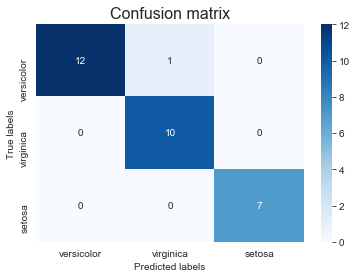

In [37]:
ax= plt.subplot()
sns.heatmap(cm_lr, annot=True, cmap="Blues", ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title("Confusion matrix", fontsize=16)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.savefig("plot4.png")
plt.show()

In [35]:
lr_classifier.coef_

array([[-3.91326726e-01,  9.16030651e-01, -2.38698043e+00,
        -1.02249055e+00],
       [ 3.91778547e-01, -1.68061136e-01, -1.36088364e-01,
        -7.16239988e-01],
       [-4.51821491e-04, -7.47969514e-01,  2.52306879e+00,
         1.73873054e+00]])

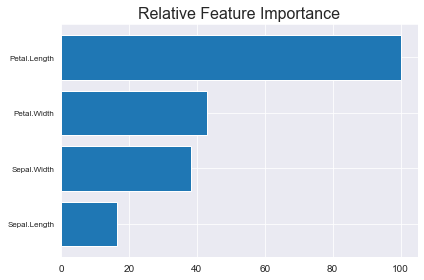

In [38]:
# let's see which variables were most important
feature_importance = abs(lr_classifier.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_title('Relative Feature Importance', fontsize=16)
plt.tight_layout()   
plt.savefig("plot5.png")
plt.show()